# **Default Setting**

* Python: 3.6.9
* ML Framework: tf-nightly-gpu 2.5.0-dev20201208
* CPU: AMD Ryzen 5 5600X 6-Core Processor
* GPU: GeForce RTX 3070 (8G) (CUDA 11.1)
* RAM: 32G
* Platform: linux 20.04 LTS

Install below APIs using anaconda.

* conda create -n py36 python=3.6.9
* conda acitvate py36
* pip3 install tf-nightly-gpu
* pip3 install tensorflow-addons
* conda install pandas, matplotlib

And now, you can run jupyter lab (or jupyter notebook).

In [1]:
%env NOTEBOOKNAME try27
%env LOCAL_DATA_PATH data
%env CHECKPOINT_PATH ckpt
%env SUBMISSION_PATH submission

env: NOTEBOOKNAME=try27
env: LOCAL_DATA_PATH=data
env: CHECKPOINT_PATH=ckpt
env: SUBMISSION_PATH=submission


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa

import datetime
import glob
import os
import platform

import numpy as np
import pandas as pd

from collections import OrderedDict
from matplotlib import pyplot as plt

print(f"tf.__version__: {tf.__version__}")
print(f"tfa.__version__: {tfa.__version__}")

tf.__version__: 2.5.0-dev20201208
tfa.__version__: 0.11.2


/home/myunggyo/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:44: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20201208). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# !python -V

In [5]:
# !cat /proc/cpuinfo

In [6]:
!nvidia-smi

Mon Dec 21 07:42:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Graphics Device     On   | 00000000:0A:00.0  On |                  N/A |
|  0%   35C    P8    19W / 220W |    354MiB /  7979MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# !df -h

In [8]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           31Gi       2.6Gi        24Gi       514Mi       4.5Gi        27Gi
Swap:         2.0Gi       1.2Gi       788Mi


In [9]:
# platform.platform()

In [10]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

# **Define Arguments**

In [11]:
args = OrderedDict({
    # Basic
    "SEED": 42,
    "TEST_SIZE": 0.2,
    "EPOCH": 10,
    "INIT_LR": 1e-3,
    
    # Dataframe
    "NUM_TEST_CSV": 81,
    
    # Dataset Pipeline
    "WINDOW_INP": 7 * 24 * 2, # 336, 7 days
    "WINDOW_TAR": 2 * 24 * 2, # 96, 2 days
    "WINDOW_SHIFT": 1 * 24 * 2, # 1 day
    "WINDOW_STRIDE": 1,
    "WINDOW_DR": True, # Drop remainders
    "AUTO": tf.data.experimental.AUTOTUNE,
    
    "GLOBAL_BATCH_SIZE": 128,
    
    # Model
    "NUM_UNITS": 64, # lstm units
    "NUM_FEATURES": 7, # Day_sin, Day_cos, DHI, DNI, WS, RH, T
    "NUM_QUANTILE": 9, # tau = 0.1 to 0.9
    
})

args

OrderedDict([('SEED', 42),
             ('TEST_SIZE', 0.2),
             ('EPOCH', 10),
             ('INIT_LR', 0.001),
             ('NUM_TEST_CSV', 81),
             ('WINDOW_INP', 336),
             ('WINDOW_TAR', 96),
             ('WINDOW_SHIFT', 48),
             ('WINDOW_STRIDE', 1),
             ('WINDOW_DR', True),
             ('AUTO', -1),
             ('GLOBAL_BATCH_SIZE', 128),
             ('NUM_UNITS', 64),
             ('NUM_FEATURES', 7),
             ('NUM_QUANTILE', 9)])

# **Load Datasets**

## **Train / Validation**

```
"""Using sklearn.model_selection.train_test_split()"""

tr_df, vl_df = train_test_split(
    df, 
    test_size = args["TEST_SIZE"]
    random_state = args["SEED"])
    
```

In [12]:
df = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "train", "train.csv"))

In [13]:
# df.head()

In [14]:
# df.describe()

In [15]:
args["SPLIT_LEN"] = int(df.shape[0] * (1. - args["TEST_SIZE"]))

tr_df = df[:args["SPLIT_LEN"]]
vl_df = df[args["SPLIT_LEN"]:]

tr_df.shape, vl_df.shape

((42048, 9), (10512, 9))

In [16]:
def preprocessing(df, is_training = True, day = 24 * 2): # 24 / 0.5 [h]
    # Drop timestampes.
    try:
        # We cannot use day features, thus there is no day-position in test dataset.
        df = df.drop(["Day"], axis = 1) 
    except:
        pass
    
    
    # Timestamp to sin/cos.
    df["Time"] = 2 * df["Hour"].map(int) + (df["Minute"].map(int) // 30)
    
    day_sin = np.sin(df["Time"] * (2 * np.pi / day))
    day_cos = np.cos(df["Time"] * (2 * np.pi / day))
        
    df.insert(loc = 0, column = "DAY_SIN", value = day_sin)
    df.insert(loc = 1, column = "DAY_COS", value = day_cos)
    
    df = df.drop(["Hour", "Minute", "Time"], axis = 1)
    
    
    # Standarize.
    for column in df.columns:
        if is_training:
            args[f"{column}_MEAN"] = df[column].mean()
            args[f"{column}_STD"] = df[column].std()
        
        df[column] = (df[column] - args[f"{column}_MEAN"]) / args[f"{column}_STD"]
        
    return df

In [17]:
tr_df = preprocessing(tr_df)
vl_df = preprocessing(vl_df, is_training = False)

In [18]:
tr_df

,DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET
0,-1.290472e-17,1.414197,-0.620599,-0.668244,-0.677079,0.527259,-2.018496,-0.690234
1,1.845897e-01,1.402098,-0.620599,-0.668244,-0.677079,0.526338,-2.018496,-0.690234
2,3.660211e-01,1.366009,-0.620599,-0.668244,-0.608733,0.651615,-2.018496,-0.690234
3,5.411897e-01,1.306547,-0.620599,-0.668244,-0.608733,0.650234,-2.018496,-0.690234
4,7.070984e-01,1.224730,-0.620599,-0.668244,-0.608733,0.809133,-2.018496,-0.690234
...,...,...,...,...,...,...,...,...
42043,-8.609084e-01,1.121958,-0.620599,-0.668244,-0.403696,1.003958,-0.138217,-0.690234
42044,-7.070984e-01,1.224730,-0.620599,-0.668244,0.074724,1.351695,-0.138217,-0.690234
42045,-5.411897e-01,1.306547,-0.620599,-0.668244,0.348107,1.644624,-0.237179,-0.690234
42046,-3.660211e-01,1.366009,-0.620599,-0.668244,0.621489,1.719237,-0.237179,-0.690234


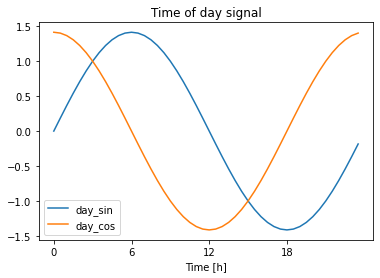

In [19]:
plt.plot(np.array(tr_df["DAY_SIN"])[:48], label = "day_sin")
plt.plot(np.array(tr_df["DAY_COS"])[:48], label = "day_cos")
plt.legend()
plt.xticks(np.arange(0, 48, 12), np.arange(0, 24, 6))
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.show()

In [20]:
tr_df.describe()

,DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET
count,4.204800e+04,4.204800e+04,4.204800e+04,4.204800e+04,4.204800e+04,4.204800e+04,4.204800e+04,4.204800e+04
mean,1.850372e-17,-9.505334e-18,4.461170e-17,-5.542666e-17,-2.500959e-16,2.893001e-16,7.976031e-17,7.029723e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.414197e+00,-1.414197e+00,-6.205988e-01,-6.682443e-01,-1.702264e+00,-2.304841e+00,-2.711231e+00,-6.902339e-01
25%,-9.999881e-01,-9.999881e-01,-6.205988e-01,-6.682443e-01,-7.454246e-01,-7.605199e-01,-8.309515e-01,-6.902339e-01
50%,7.368986e-17,8.994911e-17,-6.205988e-01,-6.682443e-01,-1.986590e-01,4.871736e-02,-1.382169e-01,-6.902339e-01
75%,9.999881e-01,9.999881e-01,2.179613e-01,6.501994e-01,4.847981e-01,7.211627e-01,7.524418e-01,5.500317e-01
max,1.414197e+00,1.414197e+00,4.468593e+00,2.353903e+00,6.499220e+00,1.951369e+00,2.632721e+00,3.193510e+00


In [21]:
vl_df.describe()

,DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET
count,1.051200e+04,1.051200e+04,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000
mean,1.723634e-17,-1.250480e-17,-0.002051,0.009001,-0.118357,-0.193249,0.437047,0.006518
std,1.000036e+00,1.000036e+00,1.007151,0.989575,0.862562,1.062334,0.960019,1.006575
min,-1.414197e+00,-1.414197e+00,-0.620599,-0.668244,-1.702264,-2.254638,-1.919534,-0.690234
25%,-9.999881e-01,-9.999881e-01,-0.620599,-0.668244,-0.745425,-1.066805,-0.336141,-0.690234
50%,7.368986e-17,8.994911e-17,-0.620599,-0.668244,-0.267005,-0.238223,0.455556,-0.690234
75%,9.999881e-01,9.999881e-01,0.227600,0.744374,0.416452,0.568941,1.148290,0.579270
max,1.414197e+00,1.414197e+00,4.420400,2.251167,3.902083,1.951369,2.632721,3.175616


## **Test**

In [22]:
ts_filenames = [os.path.join(os.environ["LOCAL_DATA_PATH"], "test", f"{i}.csv") for i in range(args["NUM_TEST_CSV"])]
ts_dfs = [preprocessing(pd.read_csv(ts_filename), is_training = False) for ts_filename in ts_filenames]
ts_df = pd.concat(ts_dfs)

In [23]:
ts_df.head()

,DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET
0,-1.290472e-17,1.414197,-0.620599,-0.668244,0.143070,-1.069108,-0.830951,-0.690234
1,1.845897e-01,1.402098,-0.620599,-0.668244,0.143070,-1.080622,-0.821055,-0.690234
2,3.660211e-01,1.366009,-0.620599,-0.668244,0.143070,-1.077859,-0.811159,-0.690234
3,5.411897e-01,1.306547,-0.620599,-0.668244,0.143070,-1.088913,-0.801263,-0.690234
4,7.070984e-01,1.224730,-0.620599,-0.668244,0.211415,-1.089834,-0.791367,-0.690234


In [24]:
ts_df.describe()

,DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET
count,2.721600e+04,2.721600e+04,27216.000000,27216.000000,27216.000000,27216.000000,27216.000000,27216.000000
mean,1.827528e-17,-1.044301e-17,-0.051219,0.048407,-0.149449,-0.517592,0.133563,0.018580
std,1.000006e+00,1.000006e+00,0.882946,1.022026,0.869087,0.883242,1.116901,1.015137
min,-1.414197e+00,-1.414197e+00,-0.620599,-0.668244,-1.633919,-2.428276,-2.384656,-0.690234
25%,-9.999881e-01,-9.999881e-01,-0.620599,-0.668244,-0.813770,-1.223056,-0.791367,-0.690234
50%,7.368986e-17,8.994911e-17,-0.562767,-0.668244,-0.335350,-0.497529,0.030019,-0.668347
75%,9.999881e-01,9.999881e-01,0.179407,0.775765,0.279761,0.149584,0.980055,0.575297
max,1.414197e+00,1.414197e+00,4.266182,2.410978,5.815763,1.609159,2.800957,3.175510


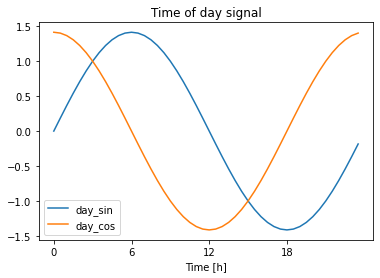

In [25]:
plt.plot(np.array(ts_df["DAY_SIN"])[:48], label = "day_sin")
plt.plot(np.array(ts_df["DAY_COS"])[:48], label = "day_cos")
plt.legend()
plt.xticks(np.arange(0, 48, 12), np.arange(0, 24, 6))
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.show()

# **Phase \#1: Target Predict Model**

## **Make Dataset Pipelines**

In [64]:
@tf.function
def _split_window(features):
    """inp: [batch, 7], tar: [batch, 1]"""
    return tf.split(features, [-1, 1], axis = 0)

In [65]:
tr_tensor = tf.constant(tr_df, dtype = tf.float32)
vl_tensor = tf.constant(vl_df, dtype = tf.float32)
ts_tensor = tf.constant(ts_df, dtype = tf.float32)

tr_dataset = tf.data.Dataset.from_tensor_slices(tr_tensor
                    ).map(_split_window, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

vl_dataset = tf.data.Dataset.from_tensor_slices(vl_tensor
                    ).map(_split_window, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

ts_dataset = tf.data.Dataset.from_tensor_slices(ts_tensor
                    ).map(_split_window, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
#                     ).cache(
                    ).prefetch(args["AUTO"])

# Print the shapes
print(f"tr_dataset: {tr_dataset.element_spec}")
print(f"vl_dataset: {vl_dataset.element_spec}")
print(f"ts_dataset: {ts_dataset.element_spec}")

tr_dataset: (TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
vl_dataset: (TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
ts_dataset: (TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))


### **Take Samples**

In [28]:
for element in tr_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 7) (128, 1)


In [29]:
for element in vl_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 7) (128, 1)


In [30]:
for element in ts_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 7) (128, 1)


## **Create Network**

```
"""Pytorch Style"""
class TARGET_MODEL(tf.keras.Model):
    def __init__(self, units, name):
        super(TARGET_MODEL, self).__init__(name = name)
        self.units = units
        
        self.dense1 = tf.keras.layers.Dense(units = self.units, activation = "relu")
        self.dense2 = tf.keras.layers.Dense(units = self.units, activation = "relu")
        self.dense3 = tf.keras.layers.Dense(units = 1)
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        
        return x            
```

In [31]:
def TARGET_MODEL(model_name, units = 64):
    model_input = tf.keras.layers.Input(shape = [7, ], dtype = tf.float32)
    
    x = tf.keras.layers.Dense(units = units, activation = "relu")(model_input)
    x = tf.keras.layers.Dense(units = units, activation = "relu")(x)    
    model_output = tf.keras.layers.Dense(1)(x)
    
    return tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)

In [108]:
tmp = TARGET_MODEL("tmp")
tmp.summary()

Model: "tmp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [109]:
# tf.keras.utils.plot_model(tmp)

In [110]:
del tmp

## **Compile and Fit**

$$ L_\tau = maximun(\tau * dy), (\tau-1) * dy)$$

* $dy$ : y_true - y_pred
* $\tau$ : Quantile values in \[0.1, 0.2, ..., 0.9\]

In [35]:
%%time

histories = []

for tau in np.arange(0.1, 1, 0.1):    
    target_model = TARGET_MODEL(
        model_name = f"T{tau:.1f}",
        units = 64)

    target_model.compile(
        loss = tfa.losses.PinballLoss(tau = tau),
        optimizer = tf.keras.optimizers.Adam(args["INIT_LR"]))
    
    # Checkpoint callback.
    ckpt_path = os.path.join(
        os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], target_model.name, "cp-{epoch:03d}-{val_loss:.4f}.ckpt")
    ckpt_dir = os.path.dirname(ckpt_path)
    os.makedirs(ckpt_dir, exist_ok = True)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, verbose = 0, monitor = "val_loss", save_weights_only = True, save_best_only = True)
    
    # TensorBoard callback.
    log_dir = os.path.join(
        "logs", "fit", os.environ["NOTEBOOKNAME"], 
        datetime.datetime.now().strftime(f"{target_model.name}-%Y%m%d-%H%M%S"))
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

    print(f"Target Model {target_model.name}...")

    history = target_model.fit(
        tr_dataset,
        validation_data = vl_dataset,
        epochs = 500,
        verbose = 0,
        callbacks = [cp_callback, tb_callback])

    histories.append(history)
    
    del target_model

Target Model T0.1...
Target Model T0.2...
Target Model T0.3...
Target Model T0.4...
Target Model T0.5...
Target Model T0.6...
Target Model T0.7...
Target Model T0.8...
Target Model T0.9...
CPU times: user 50min 3s, sys: 3min 3s, total: 53min 7s
Wall time: 33min 24s


## **Predict**

In [84]:
def load_latest_taret_models():
    """Load latest weights of target model from saved ckeckpoints."""
    ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "T*")))
    target_models = []

    for f in ckpt_folders:
        latest = tf.train.latest_checkpoint(f)
        print(f"Load latest checkpoints: {latest}...")

        # Define a new target model and load checkpoints.
        target_model = TARGET_MODEL(model_name = latest.split(os.path.sep)[2])
        ckpt = tf.train.Checkpoint(target_model)
        ckpt.restore(latest).expect_partial()

        target_models.append(target_model)
        
    return target_models

In [ ]:
# target_models = load_latest_taret_models()

# target_models[0].compile(
#     loss = tfa.losses.PinballLoss(tau = tau),
#     optimizer = tf.keras.optimizers.Adam(args["INIT_LR"]))
# target_models[0].evaluate(ts_dataset, verbose = 1)

## **Visualize**

Visualize between label and predictions.

In [38]:
def draw_history(history):
    
    plt.figure(figsize = (7, 4), facecolor = "white", dpi = 80)
    
    plt.plot(history.epoch, history.history["loss"], label = "loss")
    plt.plot(history.epoch, history.history["val_loss"], label = "val_loss")
    
    plt.legend()
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss [Pinball]")
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

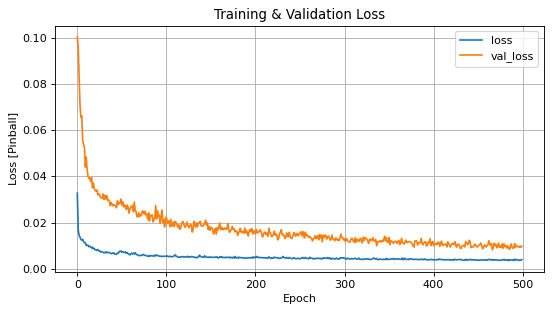

In [39]:
draw_history(histories[0])

In [ ]:
# %tensorboard --logdir logs/fit --host jupyter-server --port=6006

In [68]:
def draw_pred(y_pred, y_true, model_name, save_fig = True):
    """Draw the predictions and labels."""
    plt.figure(figsize = (14, 4), facecolor = "white")
    plt.plot(y_pred, lw = 1.5, label = "Predictions")
    plt.plot(y_true, lw = 1.5, label = "Label")
    
    plt.title(f"Target Model {model_name}")
    plt.xlabel("Time [day]")
    plt.ylabel("Target [kW]")
    plt.ylim([-0.8, max(y_true) * 1.1])
    plt.legend()
    
    plt.xticks(np.arange(0, args["WINDOW_INP"] + 1, 24 * 2), [f"D+{i}" for i in np.arange(8)])
    plt.grid(True)
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(f"./pngs/{os.environ['NOTEBOOKNAME']}_target-model-{model_name}.png", dpi = 300)
        
    plt.show()

Load latest checkpoints: ckpt/try27/T0.1/cp-467-0.0082.ckpt...
Load latest checkpoints: ckpt/try27/T0.2/cp-474-0.0116.ckpt...
Load latest checkpoints: ckpt/try27/T0.3/cp-478-0.0143.ckpt...
Load latest checkpoints: ckpt/try27/T0.4/cp-478-0.0167.ckpt...
Load latest checkpoints: ckpt/try27/T0.5/cp-495-0.0158.ckpt...
Load latest checkpoints: ckpt/try27/T0.6/cp-499-0.0156.ckpt...
Load latest checkpoints: ckpt/try27/T0.7/cp-403-0.0189.ckpt...
Load latest checkpoints: ckpt/try27/T0.8/cp-369-0.0149.ckpt...
Load latest checkpoints: ckpt/try27/T0.9/cp-462-0.0087.ckpt...


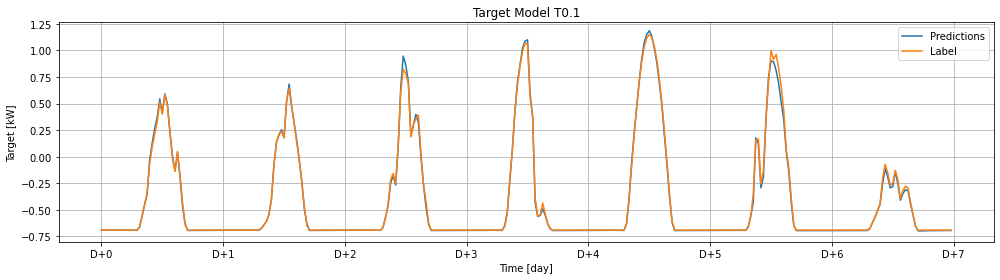

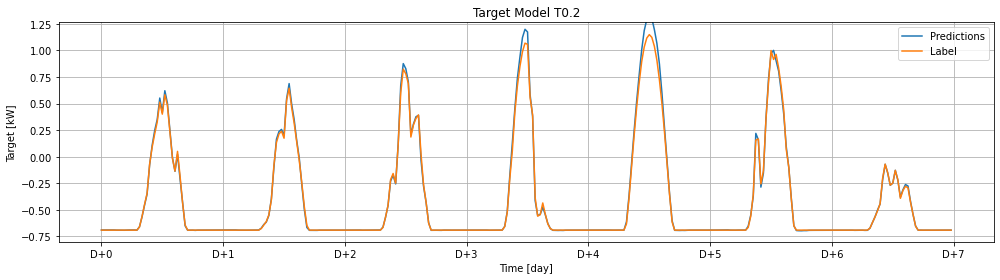

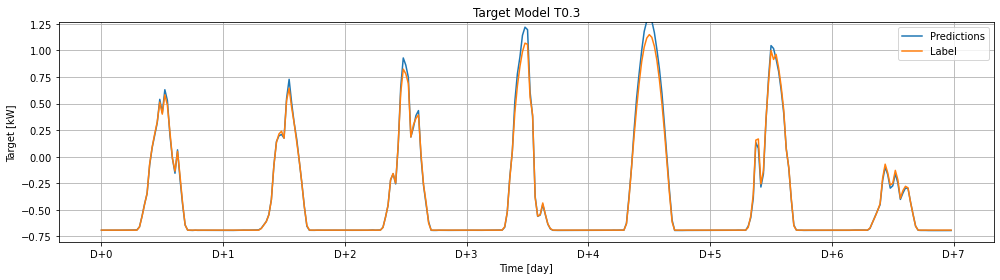

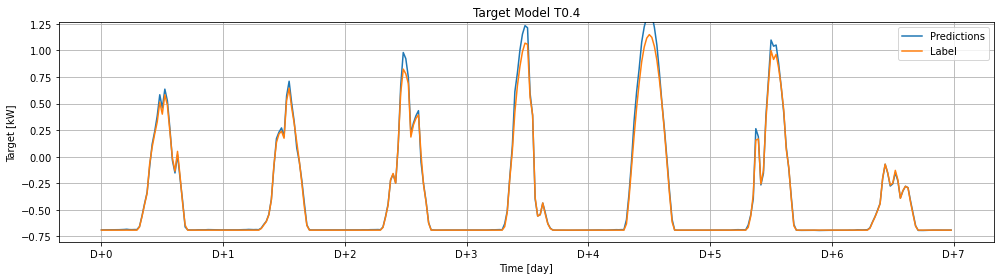

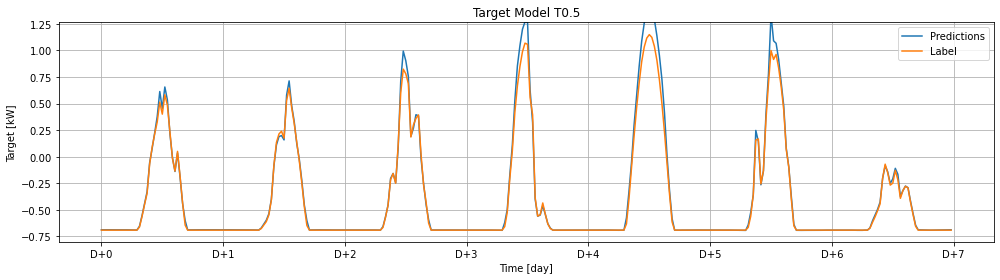

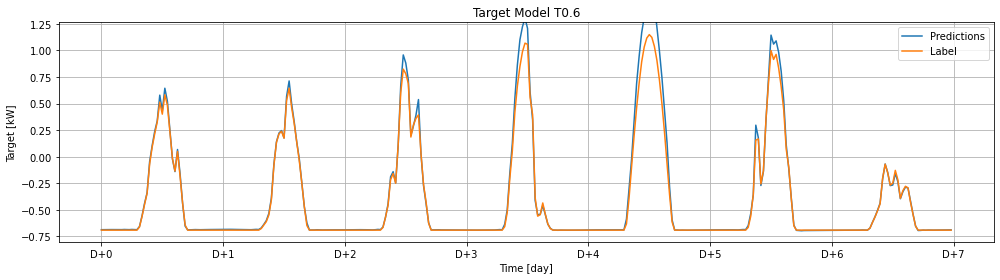

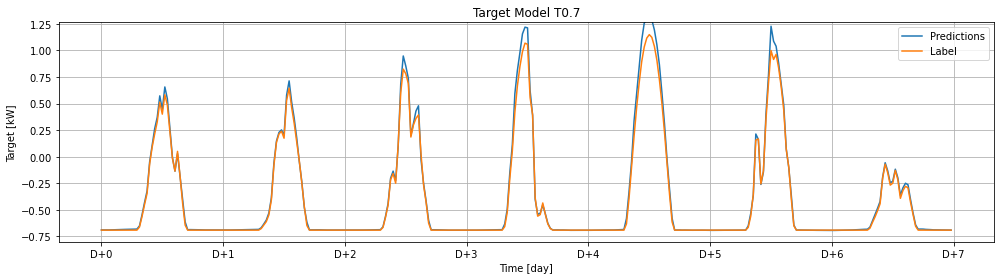

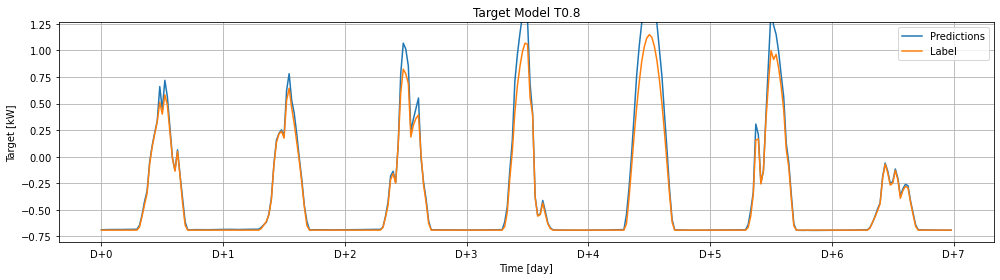

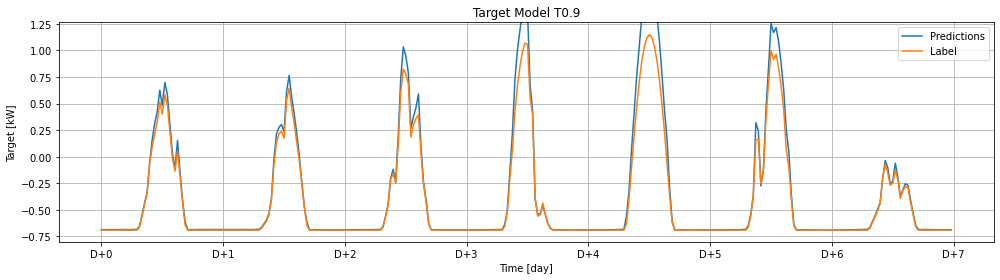

In [69]:
ts_dataset = ts_dataset.unbatch().batch(args["WINDOW_INP"])
target_models = load_latest_taret_models()

for t in ts_dataset.take(1):
    x, y = t # inp, tar
    
    for target_model in target_models:
        draw_pred(y_pred = target_model.predict(x), y_true = y, model_name = target_model.name)

# **Phase \#2: Autoregressive Model**

## **Make Dataset Pipelines**

In [70]:
@tf.function
def _flat_fn_tr(x):
    return x.batch(args["WINDOW_INP"] + args["WINDOW_TAR"])


@tf.function
def _flat_fn_ts(x):
    return x.batch(args["WINDOW_INP"])


@tf.function
def _split_window_tr(features):
    """inp: [batch, 336, 7], tar: [batch, 96, 1]"""
    inp, tar = tf.split(features, [args["WINDOW_INP"], args["WINDOW_TAR"]], axis = 0)
    return inp[..., :-1], tar[..., -1:] 


@tf.function
def _split_window_ts(features):
    """inp: [batch, 336, 7]"""
    return features[..., :-1]

In [71]:
del tr_dataset, vl_dataset, ts_dataset

tr_dataset = tf.data.Dataset.from_tensor_slices(tr_tensor
                    ).window(args["WINDOW_INP"] + args["WINDOW_TAR"], args["WINDOW_SHIFT"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_tr
                    ).map(_split_window_tr, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

vl_dataset = tf.data.Dataset.from_tensor_slices(vl_tensor
                    ).window(args["WINDOW_INP"] + args["WINDOW_TAR"], args["WINDOW_SHIFT"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_tr
                    ).map(_split_window_tr, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

ts_dataset = tf.data.Dataset.from_tensor_slices(ts_tensor
                    ).window(args["WINDOW_INP"], args["WINDOW_INP"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_ts
                    ).map(_split_window_ts, num_parallel_calls = args["AUTO"]
                    ).batch(args["NUM_TEST_CSV"] # not args["GLOBAL_BATCH_SIZE"]
#                     ).cache(
                    ).prefetch(args["AUTO"])

# Print the shapes
print(f"tr_dataset: {tr_dataset.element_spec}")
print(f"vl_dataset: {vl_dataset.element_spec}")
print(f"ts_dataset: {ts_dataset.element_spec}")

tr_dataset: (TensorSpec(shape=(None, 336, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name=None))
vl_dataset: (TensorSpec(shape=(None, 336, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name=None))
ts_dataset: TensorSpec(shape=(None, None, 7), dtype=tf.float32, name=None)


### **Take Samples**

In [49]:
for element in tr_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 336, 7) (128, 96, 1)


In [50]:
for element in vl_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 336, 7) (128, 96, 1)


In [51]:
for element in ts_dataset.take(1):
    foo = element
    print(foo.shape)

(81, 336, 7)


## **Create Network**

In [73]:
class AR_LSTM(tf.keras.Model):
    def __init__(self, target_model, units, out_steps, name):
        super(AR_LSTM, self).__init__(name = name)
        self.target_model = target_model # [batch, 7] => [batch, 1]
        self.units = units
        self.out_steps = out_steps
        self.num_features = args["NUM_FEATURES"]
        
        self.lstm_rnn = tf.keras.layers.RNN([
            tf.keras.layers.LSTMCell(self.units),
            tf.keras.layers.LSTMCell(self.units),
            tf.keras.layers.LSTMCell(self.units)], return_state = True)
        self.dense = tf.keras.layers.Dense(self.num_features)
        
    
    def warmup(self, inputs):
        # [batch, time, features] => [batch, units]
        x, *state = self.lstm_rnn(inputs)
        # [batch, units] => [batch, num_features]
        prediction = self.dense(x)
        return prediction, state
        
        
    def call(self, inputs, training = None):
        predictions = []
        
        prediction, state = self.warmup(inputs)
        predictions.append(self.target_model(prediction))
        
        for n in range(1, self.out_steps):
            x = tf.expand_dims(prediction, axis = 1)
            # [batch, num_features] => [batch, units]
            x, *state = self.lstm_rnn(x, initial_state = state, training = training)
            # [batch, units] => [batch, num_features]
            prediction = self.dense(x)
            predictions.append(self.target_model(prediction))
            
        predictions = tf.stack(predictions, axis = 1)
        return predictions

## **Compile and Fit**

In [85]:
%%time

target_models = load_latest_taret_models()
target_models.reverse()

for tau in np.arange(0.1, 1, 0.1):
    target_model = target_models.pop()
    target_model.trainable = False # fix the weights
    
    model = AR_LSTM(
        target_model = target_model,
        units = args["NUM_UNITS"],
        out_steps = args["WINDOW_TAR"],
        name = f"P{tau:.1f}")

    model.compile(
        loss = tfa.losses.PinballLoss(tau = tau),
        optimizer = tf.keras.optimizers.Adam(args["INIT_LR"]))
    
    # Checkpoint callback.
    ckpt_path = os.path.join(
        os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], model.name, "cp-{epoch:03d}-{val_loss:.4f}.ckpt")
    ckpt_dir = os.path.dirname(ckpt_path)
    os.makedirs(ckpt_dir, exist_ok = True)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, verbose = 0, monitor = "val_loss", save_weights_only = True, save_best_only = True)
    
    # TensorBoard callback to visualize loss & val_loss.
    log_dir = os.path.join(
        "logs", "fit", os.environ["NOTEBOOKNAME"], 
        datetime.datetime.now().strftime(f"{model.name}-%Y%m%d-%H%M%S"))
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

    print(f"\nModel {model.name}...\n")
    
    _ = model.fit(
        tr_dataset,
        validation_data = vl_dataset,
        epochs = args["EPOCH"],
        verbose = 2,
        callbacks = [cp_callback, tb_callback])
    
    del target_model, model # for save memories

Load latest checkpoints: ckpt/try27/T0.1/cp-467-0.0082.ckpt...
Load latest checkpoints: ckpt/try27/T0.2/cp-474-0.0116.ckpt...
Load latest checkpoints: ckpt/try27/T0.3/cp-478-0.0143.ckpt...
Load latest checkpoints: ckpt/try27/T0.4/cp-478-0.0167.ckpt...
Load latest checkpoints: ckpt/try27/T0.5/cp-495-0.0158.ckpt...
Load latest checkpoints: ckpt/try27/T0.6/cp-499-0.0156.ckpt...
Load latest checkpoints: ckpt/try27/T0.7/cp-403-0.0189.ckpt...
Load latest checkpoints: ckpt/try27/T0.8/cp-369-0.0149.ckpt...
Load latest checkpoints: ckpt/try27/T0.9/cp-462-0.0087.ckpt...

Model P0.1...

Epoch 1/10
7/7 - 156s - loss: 0.1841 - val_loss: 0.0834
Epoch 2/10
7/7 - 5s - loss: 0.0866 - val_loss: 0.0806
Epoch 3/10
7/7 - 5s - loss: 0.0784 - val_loss: 0.0756
Epoch 4/10
7/7 - 5s - loss: 0.0746 - val_loss: 0.0746
Epoch 5/10
7/7 - 5s - loss: 0.0744 - val_loss: 0.0716
Epoch 6/10
7/7 - 5s - loss: 0.0732 - val_loss: 0.0735
Epoch 7/10
7/7 - 5s - loss: 0.0733 - val_loss: 0.0714
Epoch 8/10
7/7 - 5s - loss: 0.0722 - 

In [ ]:
# models[0].summary()

In [ ]:
# %tensorboard --logdir logs/fit --host jupyter-server --port=6006

## **Predict**

In [87]:
def load_latest_models():
    """Load latest weights of target model from saved ckeckpoints."""
    ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "P*")))
    models = []

    for f in ckpt_folders:
        latest = tf.train.latest_checkpoint(f)
        print(f"Load latest checkpoints: {latest}...")

        # Define a new target model and load checkpoints.
        
        model_name = latest.split(os.path.sep)[2]
        model = AR_LSTM(
        target_model = TARGET_MODEL(model_name = f"T{model_name[1:]}"),
            units = args["NUM_UNITS"],
            out_steps = args["WINDOW_TAR"],
            name = model_name)

        ckpt = tf.train.Checkpoint(model)
        ckpt.restore(latest).expect_partial()

        models.append(model)
        
    return models

In [88]:
%%time
models = load_latest_models()
preds = [np.array(model.predict(ts_dataset))[..., 0] for model in models]

Load latest checkpoints: ckpt/try27/P0.1/cp-010-0.0693.ckpt...
Load latest checkpoints: ckpt/try27/P0.2/cp-010-0.1226.ckpt...
Load latest checkpoints: ckpt/try27/P0.3/cp-010-0.1862.ckpt...
Load latest checkpoints: ckpt/try27/P0.4/cp-010-0.1517.ckpt...
Load latest checkpoints: ckpt/try27/P0.5/cp-009-0.1658.ckpt...
Load latest checkpoints: ckpt/try27/P0.6/cp-010-0.1609.ckpt...
Load latest checkpoints: ckpt/try27/P0.7/cp-010-0.1487.ckpt...
Load latest checkpoints: ckpt/try27/P0.8/cp-010-0.1212.ckpt...
Load latest checkpoints: ckpt/try27/P0.9/cp-009-0.0811.ckpt...
CPU times: user 2min 40s, sys: 104 ms, total: 2min 40s
Wall time: 2min 40s


In [89]:
submission = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "sample_submission.csv"), index_col = "id")
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
for column, pred in zip(submission.columns, preds):
    foo = np.reshape(pred, (-1,))
    foo = (foo * args["TARGET_STD"]) + args["TARGET_MEAN"]
#     foo = np.where(foo < 0, 0, foo) # clip by value
    
    submission[column] = foo

In [91]:
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,-1.102068,-1.278736,1.216902,0.597883,1.143007,0.516880,1.435452,1.768954,0.102005
0.csv_Day7_0h30m,-1.303591,-1.891361,0.783821,0.529467,0.864021,0.377455,1.255178,1.433878,0.053030
0.csv_Day7_1h00m,-1.451220,-2.400908,0.392927,0.469427,0.762243,0.250511,1.105818,1.246538,0.102730
0.csv_Day7_1h30m,-1.524147,-2.803286,0.063932,0.381834,0.825382,0.132046,1.012205,1.241396,0.246969
0.csv_Day7_2h00m,-1.542830,-3.092854,-0.190712,0.322884,1.011703,0.006989,0.992331,1.443804,0.496706


In [92]:
submission.to_csv(
    os.path.join(os.environ["SUBMISSION_PATH"], f"{os.environ['NOTEBOOKNAME']}_submission.csv"))